In [2]:
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as T
import matplotlib.pyplot as plt

In [8]:
# Gettint the dataset
root = "data/"

transform = T.Compose([
    T.Resize((64,64)),
    T.ToTensor()
])

train_ds = datasets.FashionMNIST(root,train=True,transform=transform,download=True)
test_ds = datasets.FashionMNIST(root,train=False,transform=transform,download=True)

In [38]:
def plot_image(X):
    plt.imshow(X.squeeze(),cmap="gray")


def get_betas(T):
    beta_start = 1e-4
    beta_end = 0.1

    betas = torch.linspace(beta_start,beta_end,T)
    return betas

def calculate_alpha(betas):
    alphas = 1 - betas;
    alphas_tilda = torch.cumprod(alphas,dim=0)
    return alphas,alphas_tilda

def dummy_forward(x0,T,alpha_tilda,device="cuda"):
    if len(x0.shape) == 3:  # If single image, add batch dimension
        x0 = x0.unsqueeze(0)


    batch_size = x0.shape[0]

    sqrt_alpha_tilda_t = torch.sqrt(alpha_tilda[T-1]).view(batch_size,1,1,1).to(device)
    sqrt_one_minus_alpha_tilda_t = torch.sqrt(1-alpha_tilda[T-1]).view(batch_size,1,1,1).to(device)

    epsilon = torch.randn_like(x0).to(device)

    xt = sqrt_alpha_tilda_t*x0 + sqrt_one_minus_alpha_tilda_t*epsilon
    return xt.to(device)

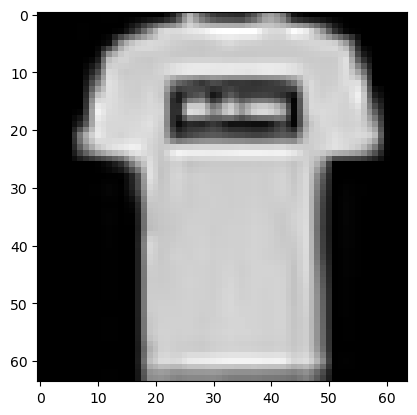

In [43]:
x,y = train_ds[1]
plot_image(x)


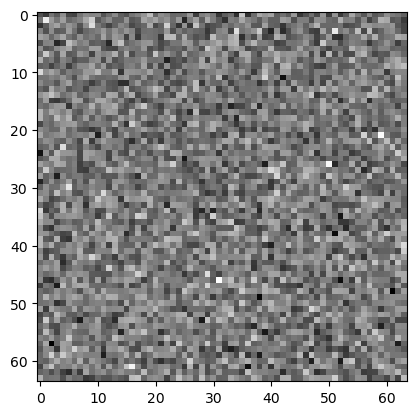

In [49]:
T = 1000
device = "cpu"
x.to(device)
betas = get_betas(T)
_,alpha_tilda = calculate_alpha(betas)

xT = dummy_forward(x,T,alpha_tilda,device)
plot_image(xT)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class SqueezeExcitation(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super().__init__()
        self.fc1 = nn.Linear(in_channels, in_channels // reduction)
        self.fc2 = nn.Linear(in_channels // reduction, in_channels)

    def forward(self, x):
        batch, channels, _, _ = x.size()
        se = F.adaptive_avg_pool2d(x, 1).view(batch, channels)
        se = F.relu(self.fc1(se))
        se = torch.sigmoid(self.fc2(se)).view(batch, channels, 1, 1)
        return x * se  


class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.relu = nn.ReLU(inplace=True)
        self.skip = nn.Conv2d(in_channels, out_channels, kernel_size=1) if in_channels != out_channels else nn.Identity()

    def forward(self, x):
        skip = self.skip(x)
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        return self.relu(x + skip)  


class DownScale(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.down = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.down(x)


class UpScale(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, (diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2))
        return torch.cat([x2, x1], dim=1)


class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, features=[64, 128, 256, 512]):
        super(UNet, self).__init__()
        self.encoder = nn.ModuleList()
        self.decoder = nn.ModuleList()
        self.attention_blocks = nn.ModuleList()

        for feature in features:
            self.encoder.append(ResidualBlock(in_channels, feature))
            in_channels = feature

        for feature in reversed(features):
            self.decoder.append(UpScale(feature * 2, feature))
            self.attention_blocks.append(SqueezeExcitation(feature))
        
        self.bottleneck = ResidualBlock(features[-1], features[-1] * 2)
        self.final = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.encoder:
            x = down(x)
            skip_connections.append(x)
            x = F.max_pool2d(x, kernel_size=2)

        x = self.bottleneck(x)

        skip_connections = skip_connections[::-1]
        for idx, (up, attn) in enumerate(zip(self.decoder, self.attention_blocks)):
            x = up(x, skip_connections[idx])
            x = attn(x)

        return self.final(x)
